# Capstone Part 4.4 - Data Preprocessing / XGboost Modelling 

In [85]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, precision_score, classification_report
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix, f1_score, recall_score
import plotly.express as px
import matplotlib.pyplot as plt

In [86]:
combhotel_clean_df = pd.read_csv('combhotel_clean_df_v2.csv')

In [87]:
combhotel_clean_df.sample(3)

,hotel,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,ArrivalDate,IsCanceled,ADR_bin,got_assigned_room
22488,resort hotel,231,2016,September,36,3,2,5,3,0,...,Transient,101.7,0,1,Check-Out,2016-09-10,2016-09-03,False,101-150,False
1326,resort hotel,8,2015,August,35,28,1,2,2,0,...,Transient,113.7,0,2,Check-Out,2015-08-31,2015-08-28,False,101-150,True
46204,city hotel,12,2017,February,6,10,0,2,2,0,...,Transient,108.0,0,0,Canceled,2017-01-29,2017-02-10,True,101-150,True


In [88]:
combhotel_clean_df.columns

Index(['hotel', 'LeadTime', 'ArrivalDateYear', 'ArrivalDateMonth',
       'ArrivalDateWeekNumber', 'ArrivalDateDayOfMonth',
       'StaysInWeekendNights', 'StaysInWeekNights', 'Adults', 'Children',
       'Babies', 'Meal', 'Country', 'MarketSegment', 'DistributionChannel',
       'IsRepeatedGuest', 'PreviousCancellations',
       'PreviousBookingsNotCanceled', 'ReservedRoomType', 'AssignedRoomType',
       'BookingChanges', 'DepositType', 'Agent', 'Company',
       'DaysInWaitingList', 'CustomerType', 'ADR', 'RequiredCarParkingSpaces',
       'TotalOfSpecialRequests', 'ReservationStatus', 'ReservationStatusDate',
       'ArrivalDate', 'IsCanceled', 'ADR_bin', 'got_assigned_room'],
      dtype='object')

In [89]:
numerical_columns = ['LeadTime', 'StaysInWeekendNights','StaysInWeekNights','Adults','Children',
                   'Babies','PreviousCancellations','PreviousBookingsNotCanceled', 'BookingChanges',
                   'DaysInWaitingList','ADR','RequiredCarParkingSpaces','TotalOfSpecialRequests']

binary_columns = ['IsCanceled', 'IsRepeatedGuest', 'got_assigned_room']

categorical_columns = ['hotel','Meal', 'Country', 'MarketSegment', 'DistributionChannel',
                       'ReservedRoomType', 'AssignedRoomType','DepositType', 'Agent', 'Company',
                       'CustomerType','ReservationStatus', 'ADR_bin']

date_not_datetime_columns = ['ArrivalDateYear','ArrivalDateMonth','ArrivalDateWeekNumber','ArrivalDateDayOfMonth']

datetime_columns = ['ReservationStatusDate','ArrivalDate']

# Preprocessing

Selecting feature columns

In [90]:
feature_cols = ['hotel','LeadTime', 'ArrivalDateMonth','StaysInWeekendNights', 'StaysInWeekNights','MarketSegment',
                'DistributionChannel','IsRepeatedGuest','CustomerType','ADR_bin','got_assigned_room']

cat_cols = ['hotel', 'ArrivalDateMonth','MarketSegment','DistributionChannel','CustomerType', 'ADR_bin']

binary_cols =  ['IsRepeatedGuest', 'got_assigned_room']

num_cols = ['LeadTime','StaysInWeekendNights','StaysInWeekNights']

In [91]:
combhotel_preprocess_df = combhotel_clean_df[feature_cols]

**one-hot encode**

In [92]:
for col in cat_cols:
    combhotel_preprocess_df = pd.concat([combhotel_preprocess_df,pd.get_dummies(combhotel_preprocess_df[col], prefix= col, drop_first= True)],axis = 1)

Dropping original category columns

In [93]:
combhotel_preprocess_df = combhotel_preprocess_df.drop(cat_cols,axis = 1)

In [94]:
combhotel_preprocess_df.columns

Index(['LeadTime', 'StaysInWeekendNights', 'StaysInWeekNights',
       'IsRepeatedGuest', 'got_assigned_room', 'hotel_resort hotel',
       'ArrivalDateMonth_August', 'ArrivalDateMonth_December',
       'ArrivalDateMonth_February', 'ArrivalDateMonth_January',
       'ArrivalDateMonth_July', 'ArrivalDateMonth_June',
       'ArrivalDateMonth_March', 'ArrivalDateMonth_May',
       'ArrivalDateMonth_November', 'ArrivalDateMonth_October',
       'ArrivalDateMonth_September', 'MarketSegment_Complementary',
       'MarketSegment_Corporate', 'MarketSegment_Direct',
       'MarketSegment_Groups', 'MarketSegment_Offline TA/TO',
       'MarketSegment_Online TA', 'DistributionChannel_Direct',
       'DistributionChannel_GDS', 'DistributionChannel_TA/TO',
       'CustomerType_Group', 'CustomerType_Transient',
       'CustomerType_Transient-Party', 'ADR_bin_101-150', 'ADR_bin_151-200',
       'ADR_bin_201-250', 'ADR_bin_251-300', 'ADR_bin_301-350',
       'ADR_bin_351-400', 'ADR_bin_401-450', 'ADR_b

## train_test_split


In [95]:
X = combhotel_preprocess_df
y = combhotel_clean_df['IsCanceled']

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify= y)

## Training a model using XGBoost

In [97]:
xgb = XGBClassifier(
    objective='binary:logistic',
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    # Adjusting class weights during training to boost minority class importance
    scale_pos_weight=12 
)

In [98]:
xgb.fit(X_train, y_train)

c:\Users\yingw\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [01:45:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [99]:
y_pred_proba = xgb.predict_proba(X_test)[:, 1]

In [100]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

In [101]:
target_precision = 0.60

In [102]:
index_for_target_precision = np.argmax(precision >= target_precision)

In [103]:
if index_for_target_precision == 0 and precision[0] < target_precision:
    # This case means the target precision is too high and was never reached
    optimal_threshold = thresholds[-1] 
    print(f"⚠️ Warning: Target precision of {target_precision:.2f} was not reached.")
else:
    # Use the threshold corresponding to the target precision index
    # Note: The thresholds array is one element shorter than precision/recall arrays
    optimal_threshold = thresholds[index_for_target_precision]
    print(f"✅ Found Threshold for Target Precision.")

✅ Found Threshold for Target Precision.


In [104]:
y_pred_custom = (y_pred_proba >= optimal_threshold).astype(int)

In [105]:
# --- 6. Evaluate Final Performance ---
print("\n" + "="*50)
print(f"| OPTIMIZATION SUMMARY (Target Precision: {target_precision*100:.0f}%) |")
print("="*50)
print(f"-> Selected Decision Threshold: {optimal_threshold:.4f}")
print("\nClassification Report with Custom Threshold:")
# Use the new predictions for the final report
print(classification_report(y_test, y_pred_custom, target_names=['Not Canceled (0)', 'Canceled (1)']))

# Display the resulting Precision/Recall at the chosen threshold
final_precision = precision_score(y_test, y_pred_custom)
final_recall = recall_score(y_test, y_pred_custom)
print(f"\nResulting Precision for Canceled (1): {final_precision:.4f}")
print(f"Resulting Recall for Canceled (1): {final_recall:.4f}")


| OPTIMIZATION SUMMARY (Target Precision: 60%) |
-> Selected Decision Threshold: 0.9212

Classification Report with Custom Threshold:
                  precision    recall  f1-score   support

Not Canceled (0)       0.77      0.93      0.84     12591
    Canceled (1)       0.60      0.27      0.38      4797

        accuracy                           0.75     17388
       macro avg       0.69      0.60      0.61     17388
    weighted avg       0.72      0.75      0.71     17388


Resulting Precision for Canceled (1): 0.6000
Resulting Recall for Canceled (1): 0.2745


## Confusion matrix

In [106]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [107]:
cm = confusion_matrix(y_test, y_pred_custom)

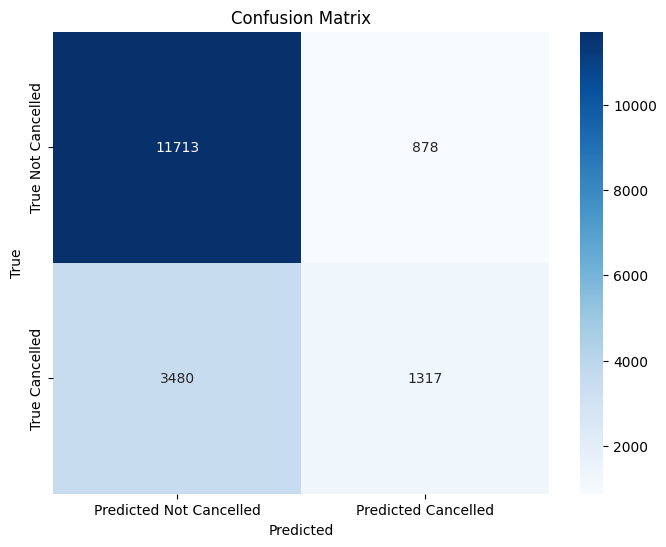

In [108]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Not Cancelled', 'Predicted Cancelled'], yticklabels=['True Not Cancelled', 'True Cancelled'])

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()